# Module 4: Het verband tussen 2 kwalitatieve variabelen

Als casus lezen we de dataset `rlanders.csv` in (die synthetische data bevat, zie [de beschrijving](../data/rlanders.md)).

In [60]:
# Importeren van de nodige packages
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import pandas as pd                                 # Dataframe
from pandas.api.types import CategoricalDtype       # Voor ordinale variabelen
import matplotlib.pyplot as plt                     # Basis visualisatie
from statsmodels.graphics.mosaicplot import mosaic  # Mozaïekdiagram
import seaborn as sns                               # Geavanceerde datavisualisatie
import altair as alt                                # Een alternatief visualisatiesysteem

In [61]:
# Inlezen dataset + data preparation
rlanders = pd.read_csv('../data/rlanders.csv')
rlanders.set_index(['ID'])
rlanders.Gender = rlanders.Gender.astype('category')
likert_scale = CategoricalDtype(categories=[1,2,3,4,5], ordered=True)
rlanders.Survey = rlanders.Survey.astype(likert_scale)
# rlanders.info()
# rlanders.Survey.dtype

## Kruistabellen en visualisatietechnieken

Stel dat we willen weten of in de steekproef vrouwen en mannen (`Gender`) verschillend antwoordden op een enquêtevraag met een Likert-schaal (`Survey`). Als de verhoudingen tussen de antwoorden (1 t/m 5) voor vrouwen en mannen ongeveer gelijk zijn, dan zeggen we dat er geen verband is tussen beide variabelen. Als er wél een aanzienlijk verschil is, dan is er wel een verband. Nu is uiteraard de vraag vanaf wanneer we spreken van een *aanzienlijk* verschil...

Een eerste stap is het berekenen van een kruistabel. We voegen hier ook meteen de marginale totalen toe:

In [62]:
pd.crosstab(rlanders.Survey, rlanders.Gender, margins=True)

Gender,Female,Male,All
Survey,,,
1,0,4,4
2,17,45,62
3,23,91,114
4,12,53,65
5,0,5,5
All,52,198,250


Zo'n tabel zegt natuurlijk niet veel. Misschien moeten we de data eens visualiseren.

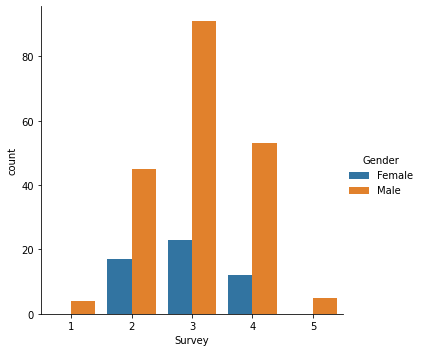

In [63]:
sns.catplot(data=rlanders, x='Survey', hue='Gender', kind='count')

Wat opvalt is dat de vrouwen alvast niet de extreme antwoorden gaven. Er zijn wel beduidend minder vrouwen in de steekproef, dus misschien moeten we eerder naar de percentages kijken.

Een mozaïekdiagram is een grafische voorstelling van de kruistabel waar elke cel voorgesteld wordt door een tegel waarvan de oppervlakte proportioneel is met de frequentie van die cel t.o.v. het totaal aantal observaties.

Je kan dit een beetje vergelijken met hoe [WinDirStat](https://windirstat.net/) de grootte van bestanden op je harde schijf visualiseert.

Voor deze casus:

(<Figure size 432x288 with 3 Axes>,
 {('Female', '1'): (0.0, 0.0, 0.19809523809523807, 0.0),
  ('Female', '2'): (0.0,
   0.029411764705882353,
   0.19809523809523807,
   0.2884615384615385),
  ('Female', '3'): (0.0,
   0.34728506787330315,
   0.19809523809523807,
   0.39027149321266974),
  ('Female', '4'): (0.0,
   0.7669683257918553,
   0.19809523809523807,
   0.20361990950226241),
  ('Female', '5'): (0.0, 1.0, 0.19809523809523807, 0.0),
  ('Male', '1'): (0.24571428571428572,
   0.0,
   0.7542857142857143,
   0.017825311942959002),
  ('Male', '2'): (0.24571428571428572,
   0.04723707664884135,
   0.7542857142857143,
   0.2005347593582888),
  ('Male', '3'): (0.24571428571428572,
   0.2771836007130125,
   0.7542857142857143,
   0.4055258467023173),
  ('Male', '4'): (0.24571428571428572,
   0.7121212121212122,
   0.7542857142857143,
   0.23618538324420674),
  ('Male', '5'): (0.24571428571428572,
   0.9777183600713012,
   0.7542857142857143,
   0.022281639928698797)})

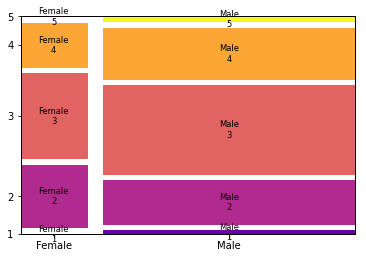

In [64]:
from matplotlib import cm

# By default, mosaic() will color all columns the same. Here,
# we're going to give a separate color to each response (1-5).
# The response is kept in the label of each cell, a tuple of
# the two values that are represented in that cell (e.g. 
# ('Female', '2')). We will be using the "plasma" color map
# in this example.
plasma_colors = cm.get_cmap('plasma')
# Create a function that maps the cell key to the color we
# want to give it. We use the colormap function created above
# and give it a number between 0 and 1. We convert the second
# part of the key (values '1' to '5') to a number and divide
# by 5.
props = lambda key: {'color': plasma_colors(int(key[1])/5)}

mosaic(data=rlanders, index=['Gender', 'Survey'],
       gap=0.05, properties=props)

We zien hier duidelijk dat de mannen meer vertegenwoordigd zijn in de steekproef (bredere tegels).

Je kan ook de verdelingen van de gegeven antwoorden op de enquêtevraag vergelijken. Op het feit na dat de vrouwen geen extreme antwoorden gegeven hebben (1 en 5), lijken de verdelingen op het eerste zicht nog vrij goed overeen te komen.

## Chi-kwadraat en Cramér's V

Chi-kwadraat en Cramér's V zijn statistieken waarmee we kunnen bepalen of er een verband bestaat tussen twee kwalitatieve (categorische) variabelen.

De redenering gaat als volgt: als er geen verband is tussen de `Survey` en `Gender`, dan verwachten we dat de verhoudingen tussen de waarden van `Survey` gelijk zijn voor alle waarden van `Gender`. M.a.w. bij zowel de vrouwen als de mannen geeft hetzelfde percentage respondenten hetzelfde antwoord op de vraag.

In [65]:
observed = pd.crosstab(rlanders.Survey, rlanders.Gender)
row_sums = observed.sum(axis=1)
col_sums = observed.sum()
n = row_sums.sum()

print(row_sums)
print(col_sums)
print(f'Aantal observaties: {n}')

Survey
1      4
2     62
3    114
4     65
5      5
dtype: int64
Gender
Female     52
Male      198
dtype: int64
Aantal observaties: 250


Nu kunnen we berekenen hoe vaak we kunnen verwachten dat elke combinatie van `Gender` en `Survey` voorkomt in de steekproef. Bijvoorbeeld 114 van de 250 respondenten heeft "3" geantwoord, m.a.w. 114/250 = 0,456 (of 46,6%). Dan weten we dat zowel 46,6% van de vrouwen als 46,6% van de mannen "3" moet geantwoord hebben. Aangezien er 52 vrouwelijke respondenten waren, verwachten we dus dat er 52 x 0,456 = 23,712 "3" geantwoord hebben. In werkelijkheid waren het er ook 23. Bij de mannen verwachten we 198 x 0,456 = 90,288 (tegenover 91 in werkelijkheid).

Dit principe kunnen we veralgemenen naar elke cel in de tabel: $\frac{rijtotaal \times kolomtotaal}{n}$ (met $n$ het totaal aantal observaties).

De verwachte waarden kunnen we dan berekenen met de `outer()` functie:

In [66]:
expected = np.outer(row_sums, col_sums) / n
expected

array([[ 0.832,  3.168],
       [12.896, 49.104],
       [23.712, 90.288],
       [13.52 , 51.48 ],
       [ 1.04 ,  3.96 ]])

Kloppen de rij- en kolomsommen nog?

In [67]:
exp_row_sums = np.sum(expected, axis=1)
exp_col_sums = np.sum(expected, axis=0)

print(f'Rijsommen  : {exp_row_sums}')
print(f'Kolomsommen: {exp_col_sums}')
print(f'Observaties: {exp_col_sums.sum()}')

Rijsommen  : [  4.  62. 114.  65.   5.]
Kolomsommen: [ 52. 198.]
Observaties: 250.0


Inderdaad, alles klopt. Wat is nu het verschil tussen de verwachte en geobserveerde waarden?

In [68]:
expected - observed

Gender,Female,Male
Survey,,
1,0.832,-0.832
2,-4.104,4.104
3,0.712,-0.712
4,1.520,-1.520
5,1.040,-1.040


Sommige geobserveerde waarden lijken dicht bij de verwachte te liggen (bv. voor "3"), andere liggen verderaf (bv. "2"). We moeten de verschillen echter ook in verhouding zien.

Een maat om de totale afwijking in een frequentietabel te bepalen, bestaat er uit om de verschillen tussen verwachte en geobserveerde waarden te kwadrateren (net zoals men bij variantie/standaardafwijking doet) en te delen door de verwachte waarde:

In [69]:
diffs = (expected - observed)**2 / expected
print(diffs)

Gender    Female      Male
Survey                    
1       0.832000  0.218505
2       1.306050  0.343003
3       0.021379  0.005615
4       0.170888  0.044880
5       1.040000  0.273131


De som van al deze waarden wordt $\chi^2$ ("chi-kwadraat") genoemd.

In [70]:
chi_squared = diffs.sum().sum()
print('χ² ≈ %.3f' %chi_squared)

χ² ≈ 4.255


Nu zegt deze waarde op zich nog steeds niet zo veel. Onder welke voorwaarden zeggen we dat er al dan niet een verband is tussen beide variabelen? Dat zal ook afhangen van de grootte van de tabel en het totaal aantal observaties. In een kruistabel met meer rijen/kolommen, zal je een grotere $\chi^2$ moeten hebben om te besluiten dat er een verband is.

[Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V) is een formule waarmee de $\chi^2$ kan genormaliseerd worden tot een waarde tussen 0 en 1 die onafhankelijk is van de tabelgrootte.

In [71]:
dof = min(observed.shape) - 1
cramers_v = np.sqrt(chi_squared / (dof * n))
print(cramers_v)

0.13046762087242633


Om een besluit te trekken uit dit getal, vergelijk je het met de waarden in onderstaande tabel:

| Cramér's V | Besluit            |
| :---:      | :---               |
| 0          | Geen verband       |
| 0.1        | Zwak verband       |
| 0.25       | Matig verband      |
| 0.50       | Sterk verband      |
| 0.75       | Zeer sterk verband |
| 1          | Volledig verband   |

Onze uitkomst voor Cramér's V wijst dus op een vrij zwak verband. Merk op dat Cramér's V erom gekend staat om in bepaalde gevallen te optimistisch te zijn over het verband tussen twee variabelen. Er bestaat een aangepaste formule om deze 'bias' weg te werken, maar die valt buiten het bereik van deze cursus.

Er bestaat echter nog een andere manier om te bepalen of de chi-kwadraat voldoende groot is om te besluiten dat er een verband is, nl. aan de hand van een statistische toets.

## De chi-kwadraat onafhankelijkheidstoets

Om een antwoord te vinden op de vraag vanaf wanneer de waarde van chi-kwadraat voldoende groot is om te veronderstellen dat er een verband is tussen twee variabelen, kunnen we gebruik maken van de *chi-kwadraat onafhankelijkheidstoets*.

### De chi-kwadraatverdeling

De waarde van $\chi^2$ volgt een specifieke stochastische verdeling die dan ook de $\chi^2$-verdeling genoemd wordt. Net zoals bij Student-t hangt de vorm van de dichtheidsfunctie af van het aantal vrijheidsgraden, wat in deze context $dof = (r-1)\times(k-1)$ is (met $r$ het aantal rijen in de kruistabel en $k$ het aantal kolommen).

Hieronder vind je de code om de dichtheidsfunctie van de $\chi^2$-verdeling te plotten voor een aantal vrijheidsgraden:

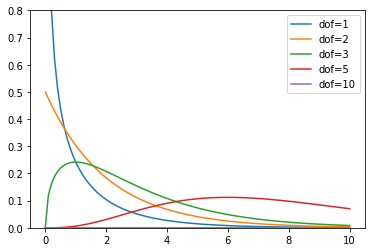

In [72]:
# Plot van de chi-kwadraatverdeling voor verschillende vrijheidsgraden
x = np.linspace(0, 10, num=100)
fig, tplot = plt.subplots(1, 1)
tplot.set_ylim([0, 0.8])
tplot.plot(x, stats.chi2.pdf(x, 1), label="dof=1") 
tplot.plot(x, stats.chi2.pdf(x, 2), label="dof=2") 
tplot.plot(x, stats.chi2.pdf(x, 3), label="dof=3")
tplot.plot(x, stats.chi2.pdf(x, 8), label="dof=5")
tplot.plot(x, stats.chi2.pdf(x, 30), label="dof=10")
tplot.legend(loc='best')

Aan de hand van deze figuur, kan je een gelijkaardige redenering volgen als bij een rechtszijdige z-toets. Je kan een kritieke grenswaarde $g$ berekenen waarvoor geldt dat de oppervlakte onder de curve rechts van $g$ gelijk is aan ons gekozen significantieniveau $\alpha$. Als de teststatistiek $\chi^2$ groter is dan $g$, zeggen we dat de afwijkingen t.o.v. de verwachte waarden in de kruistabel té groot zijn om nog op toeval te berusten en dat we dus reden hebben om aan te nemen dat er een verband is tussen beide variabelen.

Je kan ook de overschrijdingskans $p$ berekenen, d.w.z. de kans dat je de afwijkingen die je in de steekproef ziet te wijten kunnen zijn aan toevallige steekproeffouten. Daarvoor bereken je de oppervlakte onder de dichtheidscurve rechts van de $\chi^2$. Als deze oppervlakte kleiner is dan $\alpha$, zeggen we eveneens dat de afwijkingen te groot zijn om veroorzaakt te worden door toevallige steekproeffouten en dat er dus een verband is tussen de variabelen.

In Python gebruiken we daarvoor volgende Scipy-functies:

- `stats.chi2.sf(x)` - de rechterstaartkans van `x` (of "survival function")
- `stats.chi2.isf(q)` - de inverse functie van `sf(x)`, m.a.w. een getal `x` berekenen waarvoor geldt dat de rechterstaartkans precies `q` is.

Een plot voor het geval dat $\alpha = 0.05$ (een vaak gekozen waarde voor het significantieniveau) en 4 vrijheidsgraden:

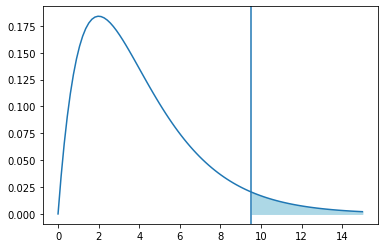

In [73]:
# Rechterstaartkans in de chi-kwadraatverdeling

# x-waarden:
x = np.linspace(0, 15, num=100)
# kansdichtheid van de chi-kwadraatverdeling met 4 vrijheidsgraden:
y = stats.chi2.pdf(x, df=4)
# het getal q waarvoor geldt dat de rechterstaartkans precies 5% is:
q = stats.chi2.isf(.05, df=4)

fig, tplot = plt.subplots(1, 1)
tplot.plot(x, y, label="dof=4")       # kansdichtheid
tplot.fill_between(x, y, where=x>=q,  # kritieke gebied
    color='lightblue')
tplot.axvline(q)                      # kritieke grenswaarde

### Toetsingsprocedure

Formeel verloopt de procedure van de $\chi^2$ onafhankelijkheidstoets als volgt:

1. Formuleer de hypotheses:
   - $H_0$: Er is geen verband tussen de variabelen (de verschillen tussen geobserveerde en verwachte waarden zijn klein)
   - $H_1$: Er is een verband tussen de variabelen (de verschillen zijn groot)
2. Bepaal het significantieniveau $\alpha$
3. Bereken de waarde van de teststatistiek (of toetsingsgrootheid) in de steekproef (hier: $\chi^2$).
4. Gebruik een van de volgende methoden (op basis van het aantal vrijheidsgraden $df = (r-1) \times (k-1)$):
   1. Bepaal de kritieke grenswaarde $g$ zodat $P(\chi^2 > g) = \alpha$
   2. Bereken de overschrijdingskans $p$
5. Trek een besluit op basis van de uitkomst:
   1. $\chi^2 < g$: $H_0$ niet verwerpen; $\chi^2 > g$: $H_0$ verwerpen
   2. $p > \alpha$: $H_0$ niet verwerpen; $p < \alpha$: $H_0$ verwerpen

In Python kunnen we dit als volgt berekenen:

In [74]:
alpha = .05
dimensions = observed.shape
dof = (dimensions[0]-1) * (dimensions[1]-1)

print("Chi-kwadraat         : %.4f" % chi_squared)
print("Vrijheidsgraden      : %d" % dof)

# Berekenen kritieke grenswaarde
g = stats.chi2.isf(alpha, df = dof)
print("Kritieke grenswaarde : %.4f" % g)

# Berekenen overschrijdingskans
p = stats.chi2.sf(chi_squared, df=dof)
print("Overschrijdingskans  : %.4f" % p)

Chi-kwadraat         : 4.2555
Vrijheidsgraden      : 4
Kritieke grenswaarde : 9.4877
Overschrijdingskans  : 0.3725


Eigenlijk hoeven we deze rekenregels om chi-kwadraat, de kritieke grenswaarde en de overschrijdingskans te bepalen niet te onthouden. In SciPy zit al een functie waarmee we op basis van een kruistabel rechtstreeks de chi-kwadraat en de p-waarde kunnen berekenen:

In [77]:
# Chi-kwadraat onanfhankelijkheidstoets op basis van een kruistabel
observed = pd.crosstab(rlanders.Survey, rlanders.Gender)
chi2, p, df, expected = stats.chi2_contingency(observed)

print("Chi-kwadraat   : %.4f" % chi2)
print("Vrijheidsgraden: %d" % df)
print("P-waarde       : %.4f" % p)

Chi-kwadraat   : 4.2555
Vrijheidsgraden: 4
P-waarde       : 0.3725


Zoals je ziet is de uitkomst voor de $p$-waarde dezelfde als in onze uitgewerkte berekeningen!

Een grafische voorstelling van onze casus:

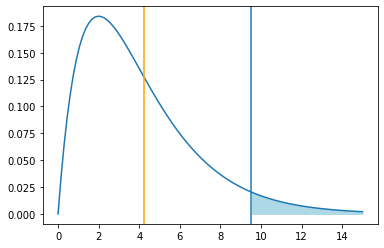

In [76]:
# Is er een verband tussen Gender en Survey?

# x-waarden:
x = np.linspace(0, 15, num=100)
# kansdichtheid van de chi-kwadraatverdeling met 4 vrijheidsgraden:
y = stats.chi2.pdf(x, df=dof)
# het getal q waarvoor geldt dat de rechterstaartkans precies 5% is:

fig, tplot = plt.subplots(1, 1)
tplot.plot(x, y)                     # kansdichtheid
tplot.fill_between(x, y, where=x>=q, # kritieke gebied
    color='lightblue')
tplot.axvline(q)                     # kritieke grenswaarde
tplot.axvline(chi2, color='orange')  # chi-kwadraat

We zien dat $\chi^2$ ruim binnen het aanvaardingsgebied ligt. De $p$-waarde is ook groter dan $\alpha$. We kunnen dus de nulhypothese niet verwerpen en besluiten dat er op basis van deze steekproef geen reden is om aan te nemen dat er een significant verschil is tussen de antwoorden van vrouwen en mannen op de enquêtevraag.

### Gestandaardiseerde residuën

TODO